In [0]:
import sys
import csv
import re
import numpy as np
import random
import codecs
from tqdm import tqdm 
from random import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import nltk
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt                                                 
import gensim

In [0]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_filters, filter_sizes, dropout):
        super(CNN, self).__init__()


        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (fs, embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
    
        #x = [sent len, batch size]
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        #pooled_n = [batch size, n_filters]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #cat = [batch size, n_filters * len(filter_sizes)]
        cat = self.dropout(torch.cat(pooled, dim=1))
            
        return self.fc(cat)


In [6]:
#Upload Files
from google.colab import files
uploaded = files.upload()

for k, v in uploaded.items():
  print(k)
 
# Supply the training tsv file and the test tsv file for subtask a

Saving testset-taskb.tsv to testset-taskb.tsv
Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv
testset-taskb.tsv
offenseval-training-v1.tsv


In [0]:
# #Download glove pre-trained word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
 


In [0]:
def case_normalization(msg):
    return msg.strip().lower()

def remove_delimiters(msg):
    #stopwords = set(nltk.corpus.stopwords.words('english'))
    #filter_func = lambda word : word not in stopwords
    filter_func = None
    return filter(filter_func, re.split('[ ,.!]', msg))

def pre_process_msg(msg):
    return remove_delimiters(case_normalization(msg))

def parse_data(input_tsv):
    lines = re.split('[\n\r]', input_tsv)
    fields = lines[0].split('\t')
    data = {}
    for field in fields:
        data[field] = []
    
    shuffle(lines)
    
    for line in lines[1:]:
        row = line.split('\t')
        if not all('' == s for s in row):
          if row[-2] != 'NULL':
            for i, token in enumerate(row):
                if token:
                    data[fields[i]].append(token)
    return data

def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w : to_index[w] if to_index.get(w) else to_index["<unk>"], seq))
    return LongTensor(idxs)

def prepare_data(text, word2idx=None):
    # Read lines and add the end of sentence symbol
    flatten = lambda l : [item for sublist in l for item in sublist]
    corpus = [sentence.strip().split() + ['</s>'] for sentence in text]

    # Create a word to index dictionary
    if word2idx == None:
        vocab = flatten(corpus)
        word2idx = {'<unk>': 0}
        for vo in vocab:
            if not word2idx.get(vo):
                word2idx[vo] = len(word2idx)

    #data = map(lambda sentence : prepare_sequence(sentence, word2idx), corpus)
    data = prepare_sequence(flatten(corpus), word2idx)
    return data, word2idx

def get_word2idx(tokenized_corpus):
    vocabulary = []
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)


    word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
    # we reserve the 0 index for the placeholder token
    word2idx['<pad>'] = 0

    return word2idx

def get_model_inputs(tokenized_corpus, word2idx, labels, max_len):
    # we index our sentences
    vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
    # we create a tensor of a fixed size filled with zeroes for padding
    sent_tensor = Variable(torch.zeros((len(vectorized_sents), max_len))).long()
    sent_lengths = [len(sent) for sent in vectorized_sents]
    # we fill it with our vectorized sentences
    for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):
        sent_tensor[idx, :sentlen] = torch.cuda.LongTensor(sent)
    label_tensor = torch.cuda.FloatTensor(labels)
    return sent_tensor, label_tensor

def predict_value(input_tensor):
    prediction = torch.sigmoid(model(input_tensor))
    return int(round(prediction.item()))
  
def pretrained_embeddings(embedding_dim, word2idx):
  
    wvecs = np.zeros((len(word2idx), embedding_dim))

    with codecs.open('glove.6B.300d.txt', 'r','utf-8') as f: 
      index = 0
      for line in tqdm(f.readlines()):
        if len(line.strip().split()) > 3:
          word = line.strip().split()[0]
          if word in word2idx:
              (word, vec) = (word, list(map(float,line.strip().split()[1:])))
              idx = word2idx[word]
              wvecs[idx] = vec

    return wvecs

testset-taskb.tsv
offenseval-training-v1.tsv
3876
525
On epoch 1 out of 15
Starting batch loop...
[01/15] mean_loss : 0.54, Perplexity : 1.71
[01/15] mean_loss : 0.36, Perplexity : 1.43
[01/15] mean_loss : 0.40, Perplexity : 1.49
[01/15] mean_loss : 0.37, Perplexity : 1.45
[01/15] mean_loss : 0.43, Perplexity : 1.53
[01/15] mean_loss : 0.39, Perplexity : 1.48
[01/15] mean_loss : 0.42, Perplexity : 1.52
Finished batch loop...
On epoch 2 out of 15
Starting batch loop...
[02/15] mean_loss : 0.39, Perplexity : 1.48
[02/15] mean_loss : 0.30, Perplexity : 1.34
[02/15] mean_loss : 0.30, Perplexity : 1.36
[02/15] mean_loss : 0.31, Perplexity : 1.37
[02/15] mean_loss : 0.40, Perplexity : 1.49
[02/15] mean_loss : 0.39, Perplexity : 1.47
[02/15] mean_loss : 0.44, Perplexity : 1.55
Finished batch loop...
On epoch 3 out of 15
Starting batch loop...
[03/15] mean_loss : 0.34, Perplexity : 1.40
[03/15] mean_loss : 0.30, Perplexity : 1.34
[03/15] mean_loss : 0.29, Perplexity : 1.34
[03/15] mean_loss : 

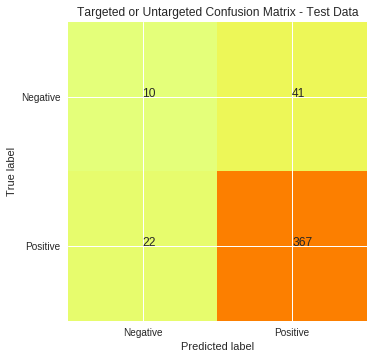

In [11]:
if __name__ == '__main__':
  
    # Hyperparameters
    EMBEDDING_SIZE = 300
    HIDDEN_LAYER_SIZE = 100
    LR = 0.01
    EPOCH = 15
    OUTPUT_DIM = 1
    N_FILTERS = 10
    FILTER_SIZES = [3, 4, 5]
    DROPOUT = 0.5
    BATCH_SIZE = 100
  
    # Parse the csv files into appropriate datasets
    for k, v in uploaded.items():
      print(k)
  
    model_dataset = parse_data(uploaded['offenseval-training-v1.tsv'])
    testing_dataset = parse_data(uploaded['testset-taskb.tsv'])

    id_values = model_dataset['id']
    model_corpus = map(pre_process_msg, model_dataset['tweet'])
    testing_corpus = map(pre_process_msg, testing_dataset['tweet'])
    off_categories = [1 if category == 'TIN' else 0 for category in model_dataset['subtask_b']]
    
    #Checking how balanced the dataset is
    tin_no = 0
    unt_no = 0
    for category in model_dataset['subtask_b']:
      if category == 'TIN':
        tin_no = tin_no + 1
      else:
        unt_no = unt_no + 1
    print(tin_no)
    print(unt_no)
    
    break_point = len(model_corpus) // 10
    training_corpus = model_corpus[:-break_point]
    training_target = off_categories[:-break_point]
    validation_corpus = model_corpus[-break_point:]
    validation_target = off_categories[-break_point:]

    # Fix seeds for consistent results
    SEED = 234
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    word2idx = get_word2idx(training_corpus)
    max_len = np.max(np.array([len(sent) for sent in training_corpus]))
    training_data_tensor, training_label_tensor = get_model_inputs(training_corpus, word2idx, training_target, max_len)
    validation_data_tensor, validation_label_tensor = get_model_inputs(validation_corpus, word2idx, validation_target, max_len)
    testing_data_tensor, _ = get_model_inputs(testing_corpus, word2idx, [], max_len)

    model = CNN(len(word2idx), EMBEDDING_SIZE, HIDDEN_LAYER_SIZE, OUTPUT_DIM, N_FILTERS, FILTER_SIZES, DROPOUT)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    #Using pretrained embeddings
#     wvecs = pretrained_embeddings(EMBEDDING_SIZE, word2idx)
#     model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

    loss_function = nn.BCEWithLogitsLoss()

    # In this class we will make use of the optimizer refer: https://pytorch.org/docs/stable/optim.html for details
    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCH):
        print("On epoch " + str(epoch + 1) + " out of " + str(EPOCH))
        total_loss = 0
        losses = []
        model.train()
        print("Starting batch loop...")
        for i in range(0, len(training_data_tensor), BATCH_SIZE):
     
            model.zero_grad()
            inputs = training_data_tensor[i : i + BATCH_SIZE].permute(1, 0).to(device)
            targets = training_label_tensor[i : i + BATCH_SIZE].unsqueeze(1).to(device)
            preds = model(inputs)
            loss = loss_function(preds, targets)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if i > 0 and i % 500 == 0:
                print("[%02d/%d] mean_loss : %0.2f, Perplexity : %0.2f" % ((epoch + 1), EPOCH, np.mean(losses), np.exp(np.mean(losses))))
                losses = []
        print("Finished batch loop...")

    model.eval()
    preds = []
    print("PREDICTING LABELS NOW")
    for validation_input in validation_data_tensor:
        model.zero_grad()
        predicted_label = predict_value(validation_input.unsqueeze(1).to(device))
        preds.append(predicted_label)
    print("FINISHED PREDICTING LABELS")

    # Temporary plot of Confusion Matrix
    acc = accuracy_score(validation_target, preds)
    f1 = f1_score(validation_target, preds, average = 'macro') 
    print("Accuracy:")
    print(acc)
    print("F1:")
    print(f1)
    cm = confusion_matrix(validation_target, preds)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    plt.title('Targeted or Untargeted Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
       for j in range(2):
           plt.text(j, i, str(cm[i][j]))
    plt.show()
    

In [0]:
model.eval()
preds = []
print("PREDICTING TESTING LABELS NOW")
for testing_input in testing_data_tensor:
    model.zero_grad()
    prediction_val = predict_value(testing_input.unsqueeze(1).to(device))
    predicted_label = "TIN" if prediction_val == 1 else "UNT"
    preds.append(predicted_label)
print("FINISHED TESTING PREDICTING LABELS")

# Write predictions into output csv file                               
csvData = []
testing_id_values = testing_dataset['id']

print(len(testing_data_tensor))
print(len(testing_id_values))
for i, id_val in enumerate(testing_id_values):                                 
   csvData.append([id_val, preds[i]])                                 
with open('predictions.csv', 'w') as csvFile:                          
   writer = csv.writer(csvFile)                                       
   writer.writerows(csvData)

files.download('predictions.csv')